# Credit Score Prediction

## Project Description

Find out where you stand on your Transunion Credit rating

# Load Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from scipy.stats import uniform, randint
import numpy as np
import keras_tuner as kt
# !pip install keras-tuner --quiet
# !pip install scikeras
# !pip install scikit-learn

Load Libraries for Project Objective

# Configuration

In [3]:
#To make the code reproducible
np.random.seed(42)
base_path = "/content/drive/MyDrive/Colab Notebooks/Tensorflow/Project/dataset/"

Load Base Path for dataset and set Seeder for reproducibility

# Data Preprocessing

## Data Information and Stats

In [4]:
# Load data
train_df = pd.read_csv(base_path + "users_data.csv")

In [5]:
# Print Shape of Train
print("Train Shape:", train_df.shape)

Train Shape: (2000, 14)


In [6]:
# Print first 5 samples of Train
print("Train Samples:")
display(train_df.head())

Train Samples:


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


Preview Dataset, the first 5 records to understand the data

In [7]:
print("Train Samples Info:")
display(train_df.info())

Train Samples Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB


None

Datatype for each features

In [8]:
print("Train Samples Statistics:")
display(train_df.describe())

Train Samples Statistics:


,id,current_age,retirement_age,birth_year,birth_month,latitude,longitude,credit_score,num_credit_cards
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,45.391500,66.237500,1973.803000,6.439000,37.389225,-91.554765,709.734500,3.073000
std,577.494589,18.414092,3.628867,18.421234,3.565338,5.114324,16.283293,67.221949,1.637379
min,0.000000,18.000000,50.000000,1918.000000,1.000000,20.880000,-159.410000,480.000000,1.000000
25%,499.750000,30.000000,65.000000,1961.000000,3.000000,33.837500,-97.395000,681.000000,2.000000
50%,999.500000,44.000000,66.000000,1975.000000,7.000000,38.250000,-86.440000,711.500000,3.000000
75%,1499.250000,58.000000,68.000000,1989.000000,10.000000,41.200000,-80.130000,753.000000,4.000000
max,1999.000000,101.000000,79.000000,2002.000000,12.000000,61.200000,-68.670000,850.000000,9.000000


Statistical values for each feature, the mean, count, std, minimum value, 25%, 50% and 75% percentiles and maximum values

## Cleaning and Checking for null Values

In [9]:
missing_values = train_df.isnull().sum()
print(missing_values)

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64


Check for null values on the dataset

In [10]:
train_df.drop_duplicates(inplace=True)

In [11]:
# Convert total_debt, per_capita_income and yearly_income column from string to numeric df
train_df['per_capita_income'] = train_df['per_capita_income'].str.lstrip('$').astype(float)
train_df['yearly_income'] = train_df['yearly_income'].str.lstrip('$').astype(float)
train_df['total_debt'] = train_df['total_debt'].str.lstrip('$').astype(float)

Strip the '$' off the income capital, yearly income and debt for data cleaning

### Feature Selection and Engineering

In [12]:
# Drop irrelevant Features
train_df.drop(columns=['id', 'address', 'latitude', 'longitude'], inplace=True)

# Bin Credit Score
# Define the bins and corresponding labels
bins = [0, 579, 669, 739, 799, 850]
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

# Apply binning with labels
train_df['credit_score_cat'] = pd.cut(train_df['credit_score'], bins=bins, labels=labels, right=True, include_lowest=True)

# One hot encoder Gender
train_df = pd.get_dummies(train_df, columns=['gender'], drop_first=True)

Feature engineering and selection. Bin credit score ranges for categorical classes to be used for classification tasks. Also one hot encoded other categorical features

## Exploratary Data Analysis

In [13]:
# Display Columns
columns = train_df.columns

print(columns)

Index(['current_age', 'retirement_age', 'birth_year', 'birth_month',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'credit_score_cat', 'gender_Male'],
      dtype='object')


List of features I will be working with

In [14]:
# Get Categorical and Continous Values
count_col = []
hist_col = []
for column in train_df.columns:
    unique_value = train_df[column].nunique()
    if unique_value <= 20:
        count_col.append(column)
    else:
        hist_col.append(column)

Get categorical columns below 20 unique records and continous values

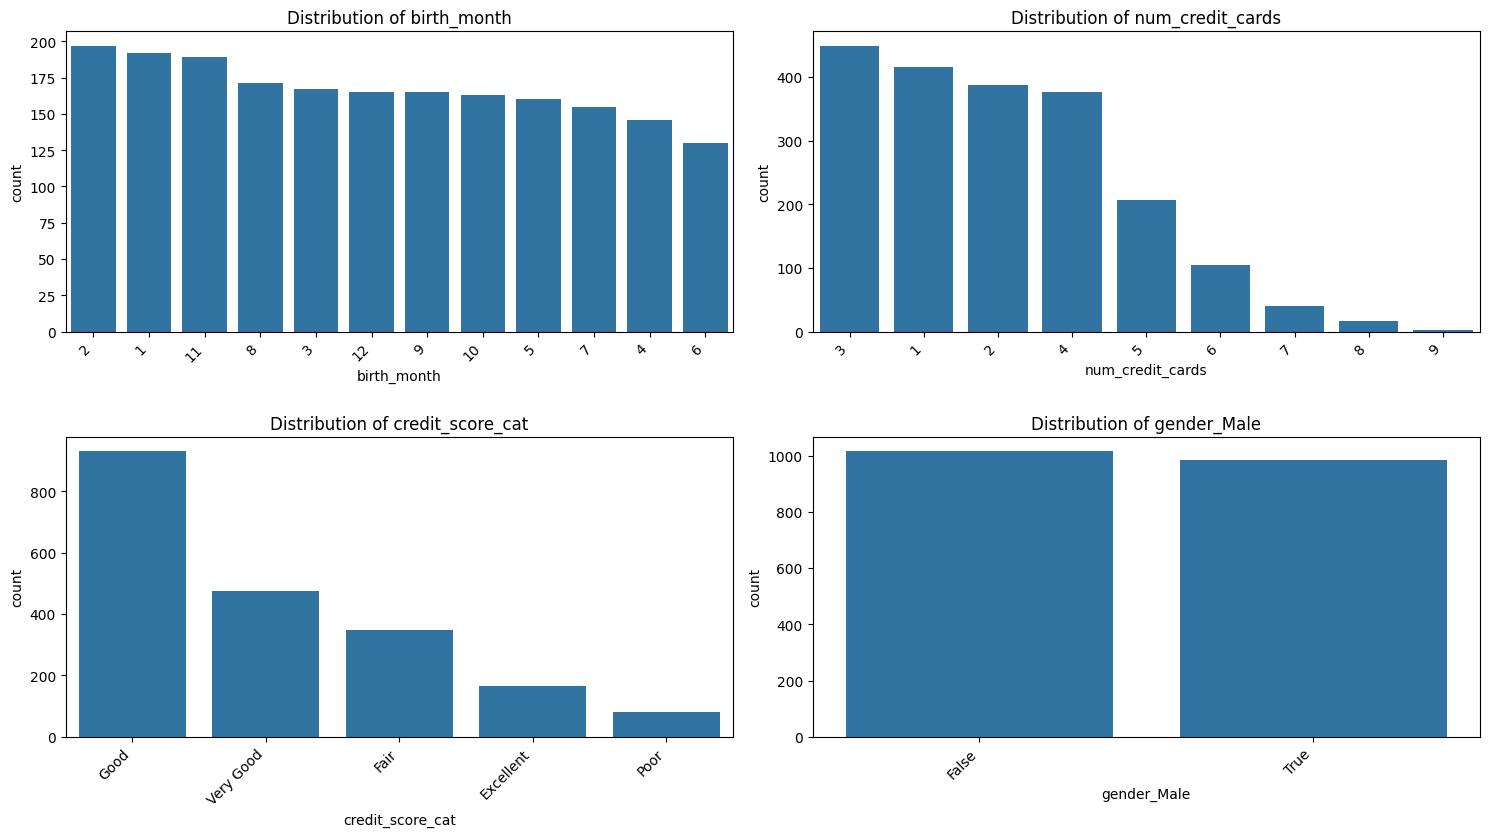

In [15]:
plt.figure(figsize=(15, 40))
plot_num = 1

for col in count_col:
    plt.subplot(10, 2, plot_num)
    sns.countplot(data=train_df, x=col,
                  order=train_df[col].value_counts().index)  # Sort by frequency

    plt.xticks(rotation=45, ha='right')
    plt.title(f"Distribution of {col}")
    plot_num += 1

plt.tight_layout()
plt.show()

These plots shows how the categorical datas are distributed

Birth month: shows how many users where born in each month on our dataset
Num of credit cards: How many users have a num of credit cards

Credit score categories: The distribution of credit score ratings

Gender: How diverse the dataset is based on genders. Women are slightly more than men

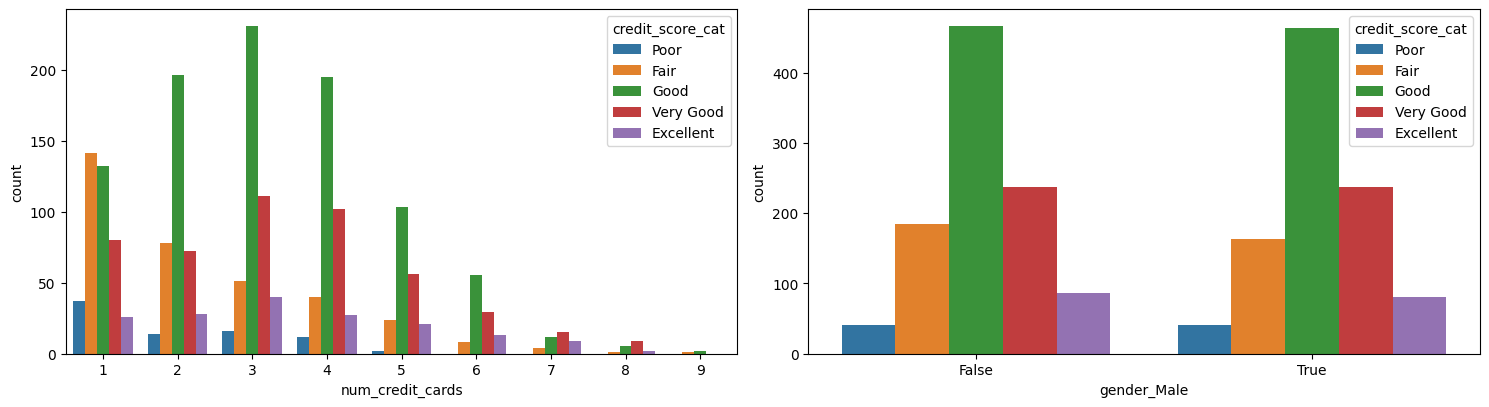

In [16]:
plt.figure(figsize=(15,40))
plot_num = 1
for col in count_col:
    if train_df[col].nunique() <= 10 and col != "credit_score_cat":
        plt.subplot(10,2,plot_num)
        sns.countplot(data=train_df, x=col, hue="credit_score_cat")
        plot_num += 1
        plt.tight_layout()

These plots show how many credit cards users have in relation to the credit score range, and the other shows how genders distributes based on the credit score ranges

## Train Test Split

In [17]:
le = LabelEncoder()
train_df['credit_score_cat'] = le.fit_transform(train_df['credit_score_cat'] )

reg_df = train_df.copy()

# Split data into train and test for Classification
X = train_df.drop('credit_score_cat', axis=1)
y = train_df['credit_score_cat']

# Split data into train and test for Regression
X_reg = train_df.drop('credit_score', axis=1)
y_reg = train_df['credit_score']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shape for training and test
# Check sizes
print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

Training set: (1600, 10)
Test set: (400, 10)


Split data into train and test. 20% test and 80% train. Above shows the distribution of the features and targets for the train and test

## Handle Class Imbalance

Original counts: {'Excellent': np.int64(138), 'Fair': np.int64(288), 'Good': np.int64(730), 'Poor': np.int64(62), 'Very Good': np.int64(382)}
After upsampling counts: {'Excellent': np.int64(730), 'Fair': np.int64(730), 'Good': np.int64(730), 'Poor': np.int64(730), 'Very Good': np.int64(730)}


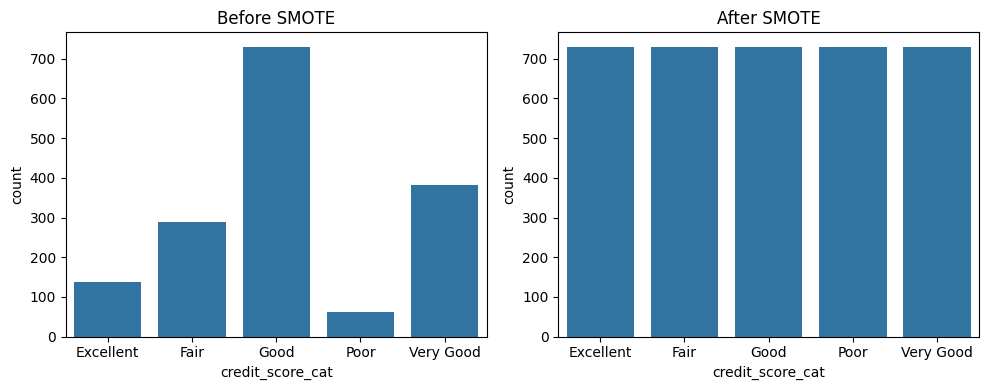

In [18]:
# Print original class distribution
print('Original counts:', dict(zip(le.classes_, np.bincount(y_train))))

# Apply SMOTE
sm = SMOTE(sampling_strategy='not majority', random_state=1)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

# Print new class distribution
print("After upsampling counts:", dict(zip(le.classes_, np.bincount(y_train_s))))

# Plot before and after
plt.figure(figsize=(10, 4))

# Before
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Before SMOTE")
plt.xticks(ticks=[0,1,2,3,4], labels=le.classes_)

# After
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_s)
plt.title("After SMOTE")
plt.xticks(ticks=[0,1,2,3,4], labels=le.classes_)

plt.tight_layout()
plt.show()

Due to the class imbalance, I performed the SMOTE technique to balance the classes across the record. The plot above shows the before & after distribution of the class.

# Model Training

## Classification

### Baseline Model - Gradient Boosting

In [19]:
# Train using the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_s, y_train_s)

# Predict the model on test set(unseen data)
y_pred_gb = gb_model.predict(X_test)

Deploy GradientBoostingClassifier using hyperparameters, n_estimators which depicts the amount of trees for training, learning_rate that controls the step size, max_depth limits the trees complexity and random_state for reproducibility

#### Evaluate

Gradient Boosting Results
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
------------------------------------------------------------
Gradient Boosting Result Visuals


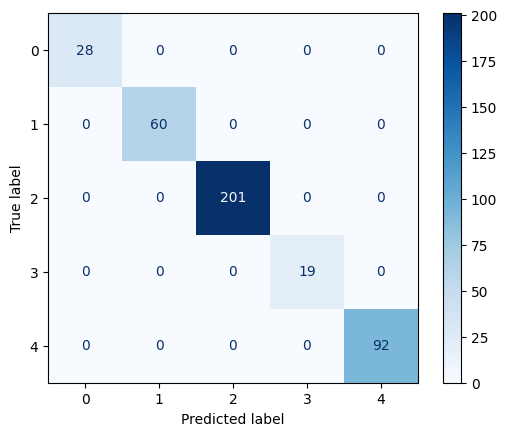

In [20]:
# Calculate accuracy, precision, recall for GB
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='macro')
recall_gb = recall_score(y_test, y_pred_gb, average='macro')

# Print Results
print("Gradient Boosting Results")
print(f"Accuracy: {accuracy_gb:.2f}")
print(f"Precision: {precision_gb:.2f}")
print(f"Recall: {recall_gb:.2f}")

print("--" * 30)

# Visualize Results
print("Gradient Boosting Result Visuals")
cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Model perfectly predicts test data, which may suggest overfitting or exceptionally clean data. The matrix shows perfect prediction across all credit score categories—no misclassifications. This confirms the 100% accuracy, though it may indicate overfitting.

### SVM Classifier

In [21]:
# Train using the Multi-Perceptron Classifier
svc_model = SVC(kernel='linear', gamma=1)
svc_model.fit(X_train_s, y_train_s)

# Predict the model on test set
y_pred_svc = svc_model.predict(X_test)

#### Evaluation

SVC Results
Accuracy: 0.97
Precision: 0.97
Recall: 0.96
------------------------------------------------------------
SVC Result Visuals


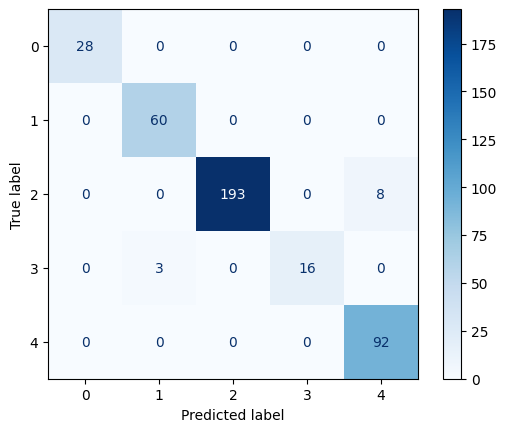

In [26]:
# Calculate accuracy, precision, recall for SVC
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc, average='macro')
recall_svc = recall_score(y_test, y_pred_svc, average='macro')

# Print Results
print("SVC Results")
print(f"Accuracy: {accuracy_svc:.2f}")
print(f"Precision: {precision_svc:.2f}")
print(f"Recall: {recall_svc:.2f}")

print("--" * 30)

# Visualize Results
print("SVC Result Visuals")
cm = confusion_matrix(y_test, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Linear SVM performs well, slightly under GB. Confusion matrix shows minimal misclassifications. A nearly perfect confusion matrix, with only a few off-diagonal errors. It confirms the high accuracy (97%) and strong performance of the SVM classifier.

### Deep Learning with Tensorflow

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_s)
X_test_scaled = scaler.transform(X_test)

# Model building
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile with optimizers and loss metrics
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train on 20 epochs with batch size of 10
history = model.fit(X_train_scaled, y_train_s, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stop])

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3172 - loss: 1.5021 - val_accuracy: 0.0795 - val_loss: 1.6223
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5598 - loss: 1.1610 - val_accuracy: 0.0521 - val_loss: 1.6362
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6604 - loss: 0.9520 - val_accuracy: 0.0575 - val_loss: 1.5528
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7173 - loss: 0.8188 - val_accuracy: 0.0575 - val_loss: 1.5296
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7662 - loss: 0.7076 - val_accuracy: 0.0849 - val_loss: 1.4156
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7938 - loss: 0.6229 - val_accuracy: 0.1123 - val_loss: 1.3562
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8248 - loss: 0.5624 - val_accuracy: 0.1808 - val_loss: 1.2544
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8394 - loss: 0.5073 - val_accuracy:

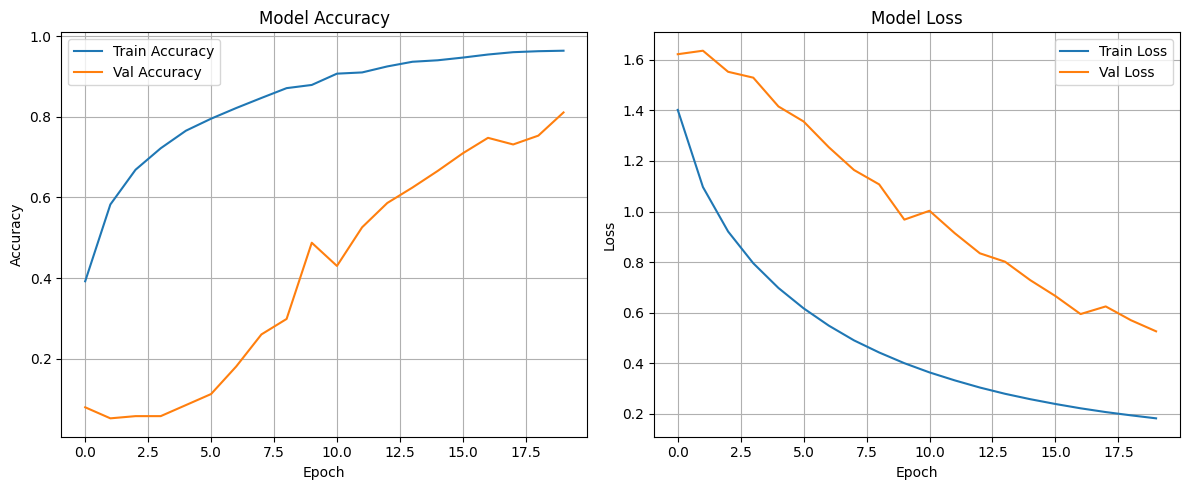

In [28]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The accuracy plot shows consistent improvement over 20 epochs, with validation accuracy peaking around 81%. The loss plot similarly decreases, indicating good learning and convergence.

#### Evaluate

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Tensorflow Results
Accuracy: 0.93
Precision: 0.90
Recall: 0.89
------------------------------------------------------------
Tensorflow Result Visuals


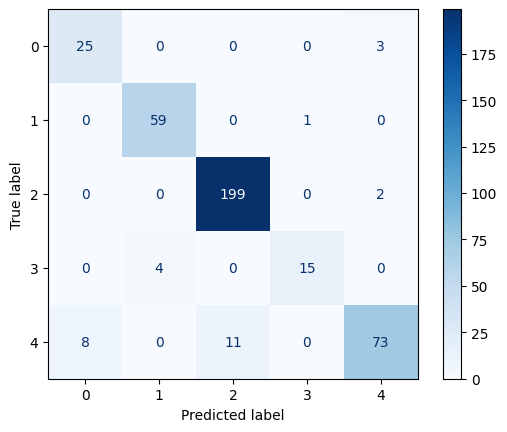

In [29]:
# Accuracy, Precision & Recall for Tensorflow
y_pred_tf = np.argmax(model.predict(X_test_scaled), axis=-1)
accuracy_tf = accuracy_score(y_test, y_pred_tf)
precision_tf = precision_score(y_test, y_pred_tf, average='macro')
recall_tf = recall_score(y_test, y_pred_tf, average='macro')

# Print Results
print("Tensorflow Results")
print(f"Accuracy: {accuracy_tf:.2f}")
print(f"Precision: {precision_tf:.2f}")
print(f"Recall: {recall_tf:.2f}")

print("--" * 30)

# Visualize Results
print("Tensorflow Result Visuals")
cm = confusion_matrix(y_test, y_pred_tf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Neural model improves steadily over 20 epochs. Final performance is strong but lower than SVM/GB. The matrix shows more misclassifications than GB and SVC. Errors mostly occur between adjacent score categories, reflecting the model’s softer performance (91% accuracy).

### Feature Importance

Feature Importance Rankings:
             Feature  GradientBoosting     SVM  NeuralNet    Mean
7       credit_score               1.0  0.8420     0.8953  0.9124
4  per_capita_income               0.0  0.0755     0.0199  0.0318
5      yearly_income               0.0  0.0690     0.0083  0.0257
2         birth_year               0.0  0.0049     0.0263  0.0104
0        current_age               0.0  0.0058     0.0169  0.0076
6         total_debt               0.0  0.0016     0.0116  0.0044
8   num_credit_cards              -0.0  0.0000     0.0094  0.0031
3        birth_month               0.0  0.0006     0.0075  0.0027
1     retirement_age               0.0  0.0006     0.0049  0.0018
9        gender_Male               0.0  0.0000     0.0000  0.0000


<Figure size 1200x800 with 0 Axes>

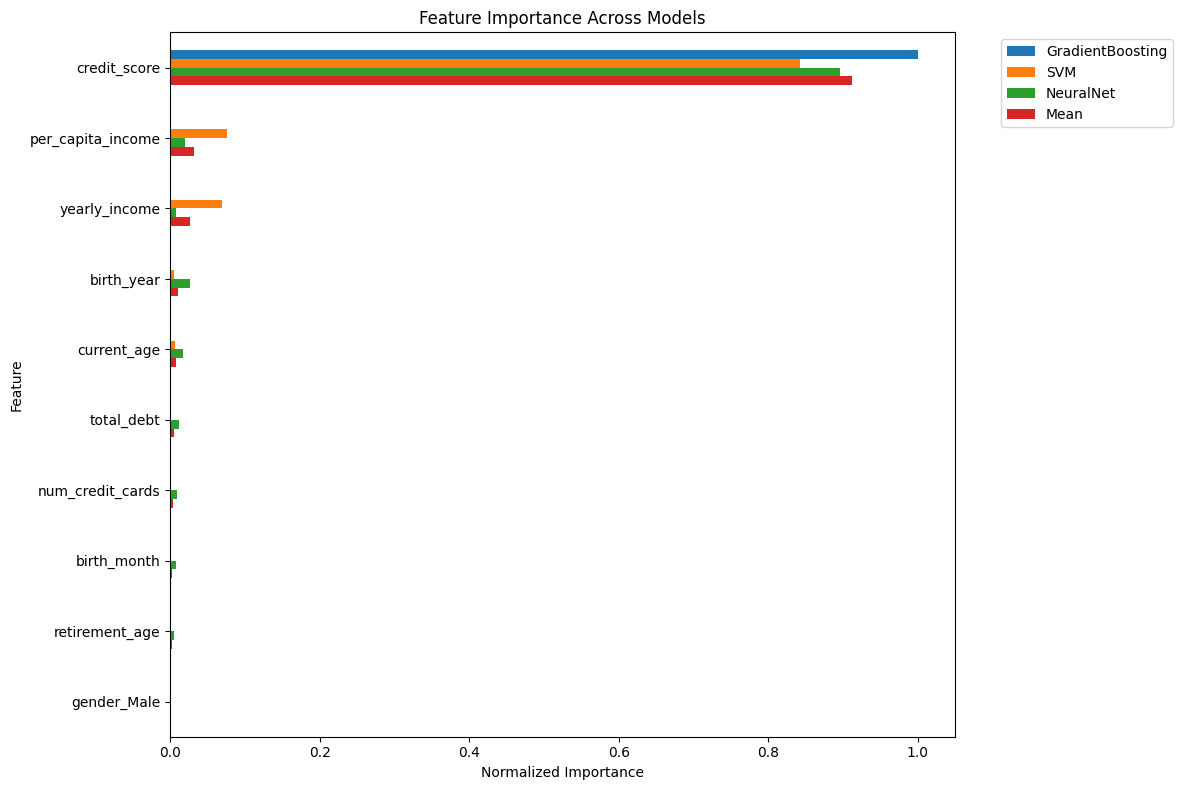

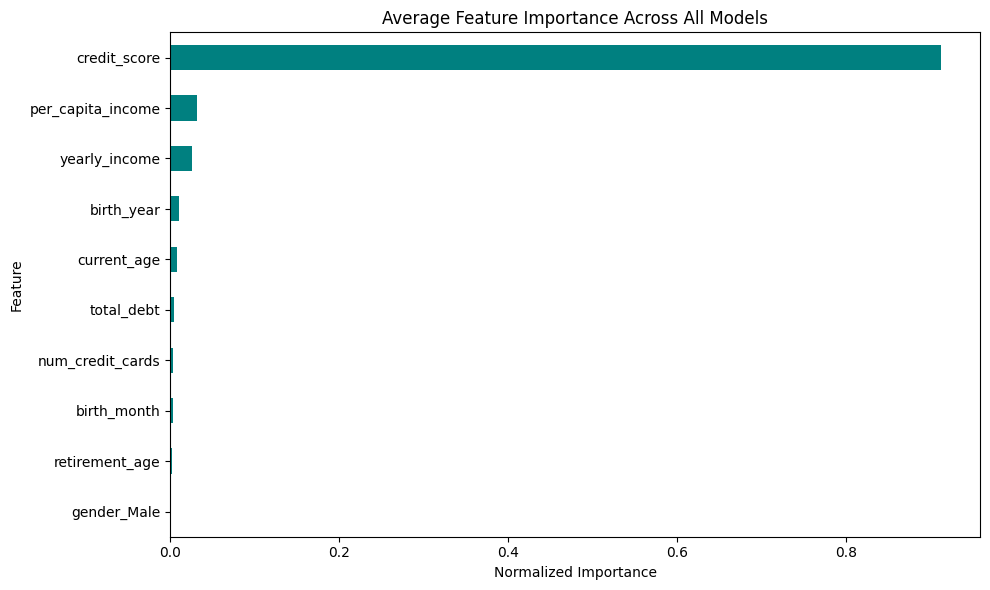

In [30]:
feature_names = X_train.columns

# 1. Gradient Boosting - Built-in feature importance
gb_importances = gb_model.feature_importances_
gb_importances /= gb_importances.sum()  # Normalize

# 2. SVM - Use permutation importance (SVM doesn't have built-in feature importance)
svm_perm_importance = permutation_importance(svc_model, X_test, y_test, n_repeats=10, random_state=42)
svm_importances = svm_perm_importance.importances_mean
svm_importances /= svm_importances.sum()  # Normalize

# 3. Neural Network - Use a simpler approach with manual permutation
def calculate_nn_permutation_importance(model, X_test, y_test, n_repeats=10):
    # Get baseline accuracy
    baseline_preds = model.predict(X_test, verbose=0)
    baseline_accuracy = np.mean(np.argmax(baseline_preds, axis=1) == y_test)

    importances = []

    for feature_idx in range(X_test.shape[1]):
        feature_importances = []

        for _ in range(n_repeats):
            # Make a copy of the test data
            X_permuted = X_test.copy()
            # Shuffle this feature
            X_permuted[:, feature_idx] = np.random.permutation(X_permuted[:, feature_idx])

            # Get predictions with shuffled feature
            perm_preds = model.predict(X_permuted, verbose=0)
            perm_accuracy = np.mean(np.argmax(perm_preds, axis=1) == y_test)

            # Importance is the drop in accuracy
            importance = baseline_accuracy - perm_accuracy
            feature_importances.append(importance)

        # Average importance across repeats
        importances.append(np.mean(feature_importances))

    return np.array(importances)

# Calculate neural network feature importance
nn_importances = calculate_nn_permutation_importance(model, X_test_scaled, y_test, n_repeats=10)
# Handle negative importances (set to 0) and normalize
nn_importances = np.maximum(nn_importances, 0)
nn_importances /= nn_importances.sum() if nn_importances.sum() > 0 else 1

# Combine into DataFrame
df = pd.DataFrame({
    "Feature": feature_names,
    "GradientBoosting": gb_importances,
    "SVM": svm_importances,
    "NeuralNet": nn_importances
})

# Calculate mean importance across all models
df["Mean"] = df[["GradientBoosting", "SVM", "NeuralNet"]].mean(axis=1)
df_sorted = df.sort_values(by="Mean", ascending=False)

# Display the results
print("Feature Importance Rankings:")
print(df_sorted.round(4))

# Plot the results
plt.figure(figsize=(12, 8))
df_sorted.set_index("Feature")[["GradientBoosting", "SVM", "NeuralNet", "Mean"]].plot(
    kind="barh",
    title="Feature Importance Across Models",
    figsize=(12, 8)
)
plt.gca().invert_yaxis()
plt.xlabel("Normalized Importance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Also create a mean-only plot for cleaner visualization
plt.figure(figsize=(10, 6))
df_sorted.set_index("Feature")["Mean"].plot(
    kind="barh",
    title="Average Feature Importance Across All Models",
    color="teal"
)
plt.gca().invert_yaxis()
plt.xlabel("Normalized Importance")
plt.tight_layout()
plt.show()

Credit score is the most important feature across all models. Other features contribute minimally. Visualizes and compares feature importance across Gradient Boosting, SVM, and Neural Network models. credit_score dominates as the key predictor, while features like gender_Male and birth_month contribute negligibly.

## Regression

### Baseline Model - Gradient Booosting

In [31]:
# Train using the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train_reg, y_train_reg)

# Predict the model on test set(unseen data)
y_pred_gbr = gbr_model.predict(X_test_reg)

#### Evaluation

In [32]:
mae_gbr = mean_absolute_error(y_test_reg, y_pred_gbr)
mse_gbr = mean_squared_error(y_test_reg, y_pred_gbr)
r2_gbr = r2_score(y_test_reg, y_pred_gbr)

print("Gradient Boosting Results")
print(f"MAE: {mae_gbr:.2f}")
print(f"MSE: {mse_gbr:.2f}")
print(f"R2 Score: {r2_gbr:.2f}")

Gradient Boosting Results
MAE: 15.92
MSE: 365.23
R2 Score: 0.92


Performs strongly in predicting actual credit scores. R² shows it explains 92% of variance.

### Deeping Learning with Tensorflow

#### Hyperparameter Tuning

In [38]:
# Scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

y_train_scaled = scaler.fit_transform(y_train_reg.values.reshape(-1, 1)).ravel()  # Flatten for KerasRegressor
y_test_scaled = scaler.transform(y_test_reg.values.reshape(-1, 1)).ravel()

# Build model function
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    # Tune number of units
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units, activation='relu'))

    model.add(Dense(1))  # Output layer

    # Tune learning rate
    hp_lr = hp.Choice('learning_rate', values=[1e-4, 1e-3, 5e-3, 1e-2])

    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='mse', metrics=['mae'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,              # Number of different models to try
    executions_per_trial=1,     # Model retrainings per trial (for stability)
    directory='my_dir',
    project_name='regression_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test_scaled, y_test_scaled)
print("Test MAE:", mae)

Trial 10 Complete [00h 00m 14s]
val_loss: 0.1132935881614685

Best val_loss So Far: 0.10953471809625626
Total elapsed time: 00h 02m 30s
Best hyperparameters: {'units': 192, 'learning_rate': 0.005}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0926 - mae: 0.2516  
Test MAE: 0.24919766187667847


#### Use Best Params

In [40]:
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train_reg.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test_reg.values.reshape(-1, 1))

# Model building
model = Sequential([
    Input(shape=(X_train_reg.shape[1],)),
    Dense(192, activation='relu'),
    Dense(1)
])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile with optimizers and loss metrics
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])

# Train on 50 epochs with batch size of 32
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.1, callbacks=[EarlyStopping(patience=5)])

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9047 - mae: 0.6939 - val_loss: 0.7759 - val_mae: 0.6292
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6543 - mae: 0.5959 - val_loss: 0.7473 - val_mae: 0.6066
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6047 - mae: 0.5791 - val_loss: 0.7326 - val_mae: 0.6011
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6059 - mae: 0.5623 - val_loss: 0.6879 - val_mae: 0.6304
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4786 - mae: 0.5085 - val_loss: 0.6497 - val_mae: 0.5304
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4807 - mae: 0.4909 - val_loss: 0.5742 - val_mae: 0.5208
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4065 - mae: 0.4588 - val_loss: 0.5750 - val_mae: 0.5081
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3918 - mae: 0.4353 - val_loss: 0.5259 - val_mae: 0.5017
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3576 - mae: 

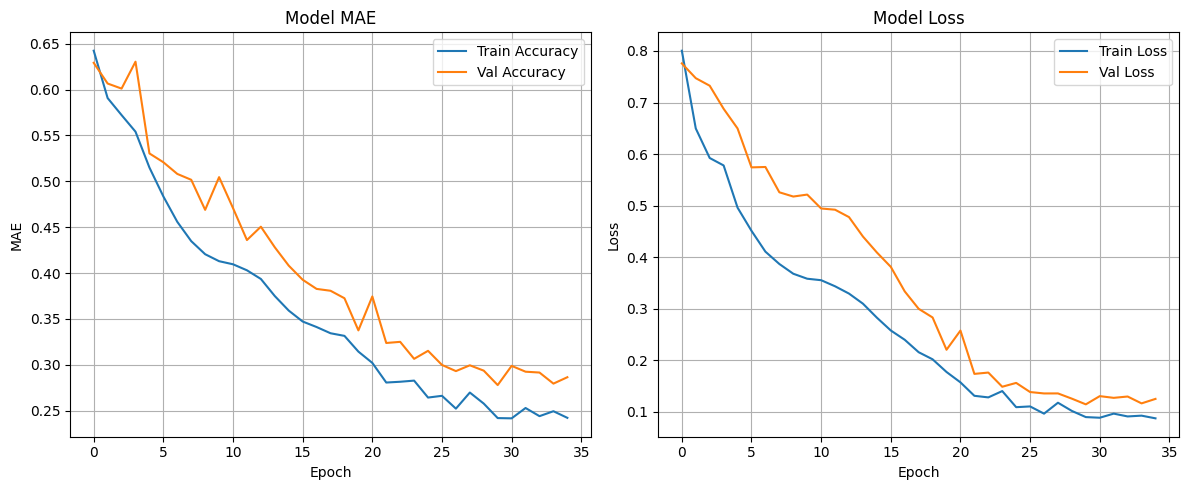

In [41]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train Accuracy')
plt.plot(history.history['val_mae'], label='Val Accuracy')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Training and validation MAE steadily decline over 20 epochs, indicating improved prediction of numeric credit scores. Loss curves follow a similar pattern with minimal overfitting.

#### Evaluate

In [42]:
# MSE, MAE AND R2SCORE FOR TENSORFLOW
y_pred_tf = model.predict(X_test_scaled)
mae_tf = mean_absolute_error(y_test_scaled, y_pred_tf)
mse_tf = mean_squared_error(y_test_scaled, y_pred_tf)
r2_tf = r2_score(y_test_scaled, y_pred_tf)

# Print Results
print("Tensorflow Results")
print(f"MAE: {mae_tf:.2f}")
print(f"MSE: {mse_tf:.2f}")
print(f"R2 Score: {r2_tf:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Tensorflow Results
MAE: 0.27
MSE: 0.11
R2 Score: 0.88


After training on scaled values, NN shows moderate performance; R² suggests weaker fit compared to GBR.



### Conclusion on Regression

Gradient Boosting outperforms TensorFlow across all regression metrics. It achieves a much lower error (MAE and MSE) and a significantly higher R² score (0.92 vs 0.88), indicating stronger predictive accuracy and a better fit to the data.